# Fachprojekt Machine Learning
**Authors:** Anastasiia Korzhylova, Ivan Shishkin, Ramneek Agnihotri, Rodi Mehi

**Due date:** Wednesday, 12. June 2024

## Import necessary components

In [1]:
# Import the necessary libraries
%load_ext autoreload
%autoreload 2

import time, warnings
from tabulate import tabulate
import torch, torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR, ExponentialLR, CosineAnnealingLR

# Import the VAE model and functions
import networks

from datasets import create_datasets
from evaluation import evaluate
from sampling import sample, plot_reconstruction
from plotting import plot_loss_lr, plot_loss_components

## Set hyperparameters, loss function and optimizing tools

In [3]:
# Hyperparameters
batch_size = 128 # Number of images per update of the network
num_epochs = 10 # One epoch means seeing every image of the training dataset
latent_dim = 256  # Size of the latent space
input_channels = 3  # CIFAR-10 images have 3 color channels
learning_rate = 2e-5 # Determines how drastically the parameters of the network change
output_frequency = 150 # Determines how often the training progress will be logged (in batches)
number_embedding_vectors = 100
embedding_dimension = 128
commitment_cost = 0.25
# Select the device that will be used for training: GPU, if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
print('=========================================')

# Put the neural network on the selected device
model = networks.VQVAE(input_channels=input_channels,emb_dim=embedding_dimension,n_embed=number_embedding_vectors,commitment_cost=commitment_cost)
model.to(device)

# Optimizer selection
optimizer_option = 'adam'

optimizer = None
if optimizer_option == "adam":
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
elif optimizer_option == "adamw":
  optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
elif optimizer_option == "rmsprop":
  optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
else:
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Learning rate scheduler parameters
lr_schedule_option = 'exponential'

scheduler = None
if lr_schedule_option == 'step':
  scheduler = StepLR(optimizer, step_size=30, gamma=0.5)
elif lr_schedule_option == 'exponential':
  scheduler = ExponentialLR(optimizer, gamma=0.9)
elif lr_schedule_option == 'cosine':
  scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-5)

# Scaler for AMP
scaler = torch.cuda.amp.GradScaler()

Using device: cuda


## Choose a dataset for training

Files already downloaded and verified
Files already downloaded and verified


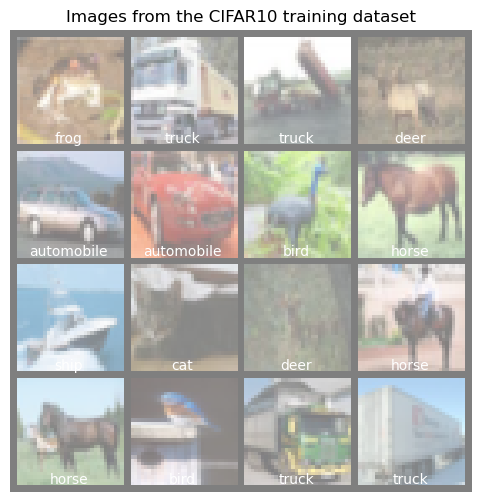

In [4]:
# Create and visualize the datasets for MNIST / CIFAR10
import numpy as np


dataset_name = 'CIFAR10'
train_loader, test_loader = create_datasets(dataset_name, batch_size)


## Training loop

In [5]:

import time
import torch
import torch.nn.functional as F
from tabulate import tabulate

# Initialize lists for tracking losses and learning rates
train_losses = []
test_losses = []
learning_rates = []
reconstruction_losses = []
vq_losses = []
commitment_losses = []
embedding_losses = []

# Training loop
for epoch in range(num_epochs):
    print('-----------------------------------------------------------------------------------------------------------------------------')
    model.train()
    batch_recon_losses = []
    batch_vq_losses = []
    batch_commitment_losses = []
    batch_embedding_losses = []
    batch_total_losses = []
    epoch_start_time = time.time()  # Start of time measurement

    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            # Forward pass
            recon_batch, vqloss, embedding_loss, commitment_loss = model(data)
            recon_loss = F.mse_loss(recon_batch, data, reduction='sum')
            loss = vqloss + recon_loss

        # Backward pass
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Save the loss values for the current batch
        curr_loss = loss.detach().item()
        curr_vqloss = vqloss.detach().item()
        curr_recon_loss = recon_loss.detach().item()
        curr_commitment_loss = commitment_loss.detach().item()
        curr_embedding_loss = embedding_loss.detach().item()
        batch_total_losses.append(curr_loss)
        batch_vq_losses.append(curr_vqloss)
        batch_recon_losses.append(curr_recon_loss)
        batch_commitment_losses.append(curr_commitment_loss)
        batch_embedding_losses.append(curr_embedding_loss)

        # Log training loss and current learning rate
        if batch_idx % output_frequency == 0:
            log = [['Epoch:', f'{epoch + 1:3d}/{num_epochs:3d}', 'Batch:', f'{batch_idx + 1:3d}',
                    'Total Loss:', f'{curr_loss:.6f}', 'VQ Loss:', f'{curr_vqloss:.6f}', 
                    'Recon Loss:', f'{curr_recon_loss:.6f}', 
                    'Commitment Loss:', f'{curr_commitment_loss:.6f}', 
                    'Embedding Loss:', f'{curr_embedding_loss:.6f}', 
                    'LR:', scheduler.get_last_lr()[0]]]
            print(tabulate(log, tablefmt="plain"))

    # Step the learning rate scheduler
    if scheduler is not None:
        lr = scheduler.get_last_lr()[0]
        scheduler.step()
    else:
        lr = learning_rate
    learning_rates.append(lr)

    # After the epoch, evaluate the accuracy on the test dataset
    mean_loss = evaluate(model, test_loader, device)
    test_losses.append(mean_loss)

    # Save the average training loss
    average_total_loss = torch.tensor(batch_total_losses).mean().item()
    average_recon_loss = torch.tensor(batch_recon_losses).mean().item()
    average_vq_loss = torch.tensor(batch_vq_losses).mean().item()
    average_commitment_loss = torch.tensor(batch_commitment_losses).mean().item()
    average_embedding_loss = torch.tensor(batch_embedding_losses).mean().item()
    train_losses.append(average_total_loss)
    reconstruction_losses.append(average_recon_loss)
    vq_losses.append(average_vq_loss)
    commitment_losses.append(average_commitment_loss)
    embedding_losses.append(average_embedding_loss)

    # End of time measurement
    elapsed_time = time.time() - epoch_start_time

    # Log epoch results
    headers = ["Epoch", "Mean Test Loss", "Time"]
    data = [[epoch + 1, f"{mean_loss:.4f}", f"{elapsed_time:.2f}s"]]
    print(tabulate(data, headers=headers, tablefmt="fancy_grid"))

    # Generate reconstructed test images after each epoch
    plot_reconstruction(model, test_loader, device, num_samples=5)
    print('-----------------------------------------------------------------------------------------------------------------------------')

# Plot Train Loss & Test Loss & LR
plot_loss_lr(num_epochs, train_losses, test_losses, learning_rates)

# Plot each loss component
plot_loss_components(reconstruction_losses, vq_losses)

# Sample some VAE-generated images
sample(model, device, latent_dim, num_samples=50)


-----------------------------------------------------------------------------------------------------------------------------


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: []